In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

# 1. Ансамбли

## Voting Classifier

Представим, что у нас имеется несколько различных обученных моделей классификации, обученных на одном и том же наборе данных

![Ensemble](https://i0.wp.com/lifewithdata.com/wp-content/uploads/2022/07/voting_classifier.jpeg)

Можно попытать устроить "голосование" между ними. Как показывает практика, это существенно улучшает предсказательную способность итоговой модели.

![Voting](https://i0.wp.com/lifewithdata.com/wp-content/uploads/2022/07/voting_classifier2.jpeg)

## Пример работы ансамбля на датасете moons

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons
import warnings
warnings.filterwarnings("ignore")

In [4]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

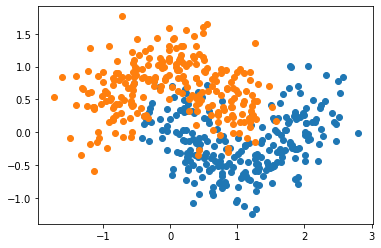

In [5]:
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

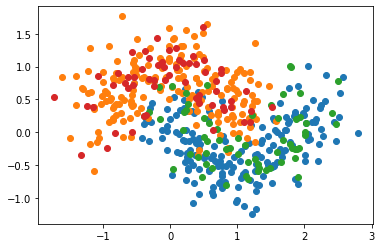

In [7]:
plt.scatter(X_train[:,0][y_train==1], X_train[:,1][y_train==1])
plt.scatter(X_train[:,0][y_train==0], X_train[:,1][y_train==0])
plt.scatter(X_test[:,0][y_test==1], X_test[:,1][y_test==1])
plt.scatter(X_test[:,0][y_test==0], X_test[:,1][y_test==0])
plt.show()

In [8]:
log_clf = LogisticRegression(random_state=42) 
tree_clf = DecisionTreeClassifier(random_state=42) 
svm_clf = SVC(kernel='rbf', random_state=42, probability=True)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)])

In [9]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.896
VotingClassifier 0.904


Видно, что ансамбль справляется чуть лучше, чем каждый из его элементов в отдельности

##  Voting может быть hard и soft
* Hard - это голосование по предсказанию меток классов
* Soft - это голосование по вероятности принадлежности к классу

In [10]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
                              voting='soft')

In [11]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.896
VotingClassifier 0.912


## А еще может быть ансамбль алгортитмов одного типа

Если обучать каждый из них на случайной подвыборке трейн сета. Различают сэмплинг подвыборок:
- C возвратом (bagging, _bootstrap aggregating_) 
- Без возврата (pasting)

![Bagging-Pasting](https://miro.medium.com/max/720/1*iskng0M2Qv9GF0CADcl0Ww.png)

## Пример: BaggingClassifier на деревьях

In [12]:
from sklearn.ensemble import BaggingClassifier

In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
bag_clf = BaggingClassifier(base_estimator=tree_clf, n_estimators=500, 
                            max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train) 
tree_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
print("Bagging: ", accuracy_score(y_test, y_pred_bag))
print("Tree: ", accuracy_score(y_test, y_pred_tree))

Bagging:  0.904
Tree:  0.856


In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

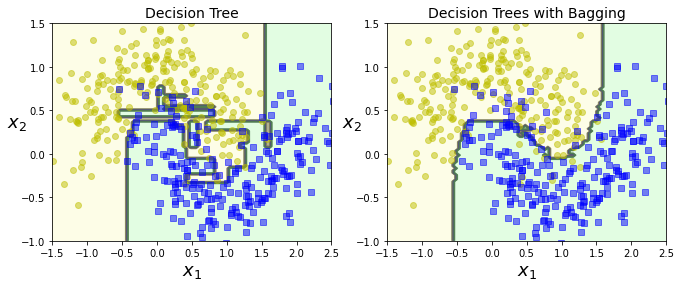

In [15]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## BaggingClassifier на решающих деревьях = RandomForest


In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rndf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                  bootstrap=True, n_jobs=-1, random_state=42)
rndf_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [18]:
y_pred = rndf_clf.predict(X_test)
print("RandomForest: ", accuracy_score(y_test, y_pred))

RandomForest:  0.912


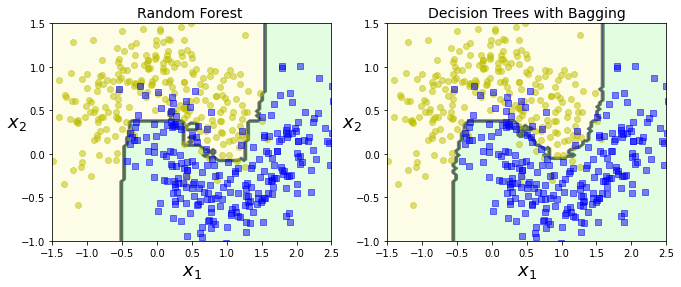

In [19]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(rndf_clf, X, y)
plt.title("Random Forest ", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Одна из фишек RandomForest - умение вычислять важность признака для классификации

Важность признака - это частота событий, когда разделение деревом имеющегося набора данных по этому признаку приводит к повышению "чистоты" получившихся подмножеств

In [20]:
from sklearn.datasets import load_iris

In [21]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


# 2. Бустинг

**Бустинг**, наравне с голосованием, это один из методов построения ансамбля. Основная его идея состоит в том, чтобы построить из моделей последовательность, в которой каждая последующая модель корректирует ошибку предыдущей модели

Методы бустинга
- AdaBoost
- Градиентный бустинг

## AdaBoost

AdaBoost делает по сути следующее: для каждой модели в последовательности он следит за тем, на каких объектах обучающей выборки плохо обучилась предыдущая модель. Этим объектам для новой модели будет присвоен больший вес при обучении.

![](https://dothanhblog.files.wordpress.com/2020/03/adaboost.png)

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5,  random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

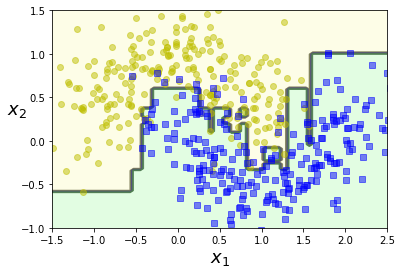

In [23]:
plot_decision_boundary(ada_clf, X, y)

Веса _ошибочных_ объектов при обучении устанавливаются с помощью параметра learning rate

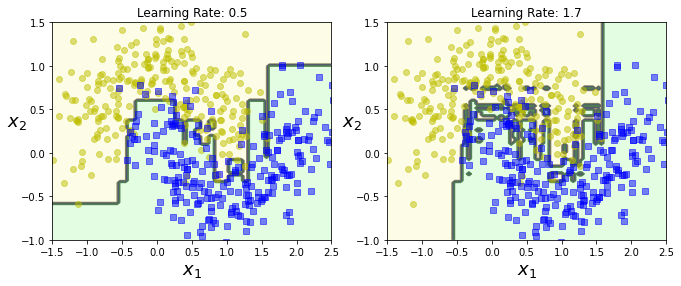

In [24]:
plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 0.5), (122, 1.7)):
    # sample_weights = np.ones(m)
    plt.subplot(subplot)
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=learning_rate,  random_state=42)
    ada_clf.fit(X_train, y_train)
    plot_decision_boundary(ada_clf, X, y)
    plt.title(f'Learning Rate: {learning_rate}')
plt.show()

## Gradient Boosting

Градиентный бустинг во многом похож на AdaBoost. Разница в том, что вместо изменения весов объектов при обучении, градиентный бустинг обучает каждую следующую модель предсказывать величину ошибки предыдущей модели.

In [25]:
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [26]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

В случае градиентного бустинга learning rate определяет не веса объектов в обучающей выборке, а вес вклада каждой отдельной модели в итоговое предсказание. Малое значение learning rate обычно требует большего числа моделей в бустинге, но лучше предсказывают данные.

Рассмотрим, как будет работать градиентный бустинг на деревьях

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [28]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

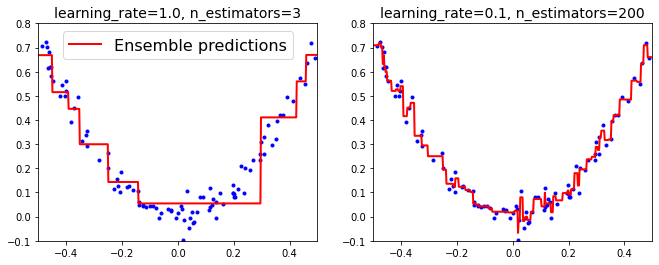

In [29]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

### Поиск оптимального числа деревьев: Gradient Boosting with Early stopping

Оптимальное число деревьев можно найти с помощью метода `staged_predict()` у класса `GradientBosstingRegressor`. Данный метод возвращает ошибку в предсказании при последовательном обучении на 1, 2, 3, и т.д. количестве деревьев вплоть до числа, указанного в n_estimators.

Построив зависимость ошибки от числа деревьев, можно оценить точку насыщения и оптимальное число деревьев.

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=65, random_state=42)

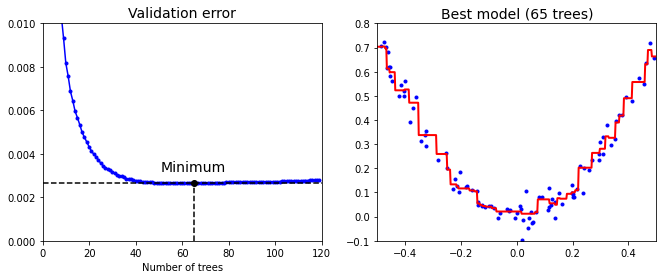

In [31]:
min_error = np.min(errors)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

### Using XGBoost

In [32]:
!pip install xgboost
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor( )
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

[20:19:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0027410914612970173


In [34]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[20:19:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.330898
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.300056
[2]	validation_0-rmse:0.273588
[3]	validation_0-rmse:0.249591
[4]	validation_0-rmse:0.228716
[5]	validation_0-rmse:0.210035
[6]	validation_0-rmse:0.192436
[7]	validation_0-rmse:0.176923
[8]	validation_0-rmse:0.163228
[9]	validation_0-rmse:0.150892
[10]	validation_0-rmse:0.13875
[11]	validation_0-rmse:0.128491
[12]	validation_0-rmse:0.119391
[13]	validation_0-rmse:0.111381
[14]	validation_0-rmse:0.104117
[15]	validation_0-rmse:0.097648
[16]	validation_0-rmse:0.091918
[17]	validation_0-rmse:0.086781
[18]	validation_0-rmse:0.082282
[19]	validation_0-rmse:0.078603
[20]	validation_0-rmse:0.074972
[21]	validation_0-rmse:0.071885
[22]	validation_0-rmse:0.068937
[23]	validation_0-rmse:0.066378
[24]	validation_0-rmse:0.064134
[25]	validation_0-rm

In [35]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [36]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

29.2 ms ± 6.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Задание 

Итак, попрактикуемся в создании ансамбля алгортимов. Твое задание состоит в следующем:

1. Сделать Voting ансамбль из SVR, DecisionTreeRegressor и LinReg, обучить его на датасете Steels Kaggle и предсказать Proof Stress на основе состава и температуры.
2. Обучить RandomForest на деревьях. Найти наилучшие параметры модели с помощью GridSearchCV.
3. Обучить XGBoost. Найти наилучшие параметры модели с помощью GridSearchCV.
4. Сравнить все подходы. Какой из методов дает наименьшую ошибку в предсказании?

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [38]:
df = pd.read_csv('Steels_kaggle.csv')
y = df[' 0.2% Proof Stress (MPa)']
X = df[[' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo', ' Cu', 'V', ' Al', ' N', 'Ceq', 'Nb + Ta', ' Temperature (°C)']]
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=43)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
y_train, y_test = y_train.ravel(), y_test.ravel()

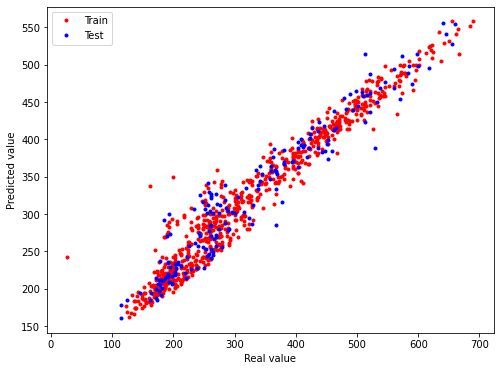

RMSE for voiting regressor (test) 47.9290734899864


In [39]:
lr_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
svm_reg = SVR(kernel='rbf')

voting_reg = VotingRegressor(estimators=[('lr', lr_reg), ('tree', tree_reg), ('svr', svm_reg)], n_jobs=-1, verbose=1)

voting_reg.fit(X_train_scaled, y_train)

y_train_pred = voting_reg.predict(X_train_scaled)
y_test_pred = voting_reg.predict(X_test_scaled)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, '.r', label='Train')
plt.plot(y_test, y_test_pred, '.b', label='Test')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()

print(f'RMSE for voiting regressor (test) {mse(y_test, y_test_pred, squared=False)}')

In [48]:
# params = {
#     'n_estimators': [50, 100, 500],
#     'max_depth': np.arange(6, 15, 4),
#     'max_leaf_nodes': [100, 250, 500, 750],
#     'min_samples_leaf': [1, 2, 3, 4, 5],
#     'min_samples_split': [1, 2, 5, 8, 10],
# }
params = {
    'n_estimators': [50, 100, 500],
    'max_depth': np.arange(6, 11, 4),
    'max_leaf_nodes': [100, 250, 500],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 5],
}

rndf_reg = RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state=43)

gs = GridSearchCV(rndf_reg, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'max_depth': 10,
  'max_leaf_nodes': 500,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 500},
 -1083.9527257937548)

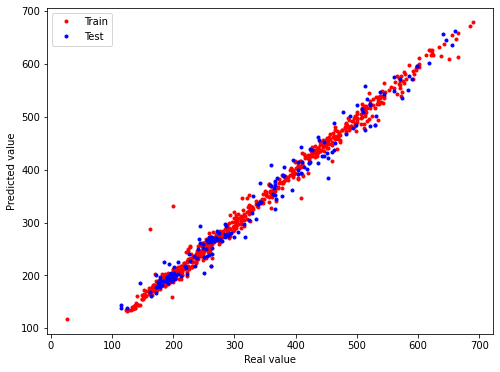

RMSE for random forest (test) 18.833081904902617


In [50]:
y_train_pred = gs.best_estimator_.predict(X_train)
y_test_pred = gs.best_estimator_.predict(X_test)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, '.r', label='Train')
plt.plot(y_test, y_test_pred, '.b', label='Test')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()

print(f'RMSE for random forest (test) {mse(y_test, y_test_pred, squared=False)}')

In [43]:
# params = {
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [2, 4, 6, 8],
#     'max_leaves': [5, 10, 100, 1000],
#     'learning_rate': [0.01, 0.05, 0.1]
# }
params = {
    'n_estimators': [500, 1000],
    'max_depth': [2, 4, 6],
    'max_leaves': [5, 10, 100],
    'learning_rate': [0.01, 0.1]
}

reg = xgboost.XGBRegressor()

gs = GridSearchCV(reg, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

[20:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 5, 'n_estimators': 1000},
 -903.8893964039833)

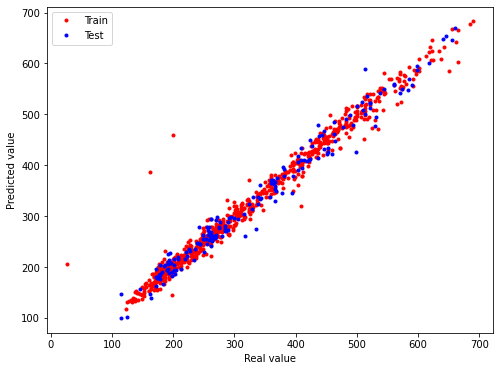

RMSE for xgboost (test) 19.212818186069008


In [46]:
y_train_pred = gs.best_estimator_.predict(X_train)
y_test_pred = gs.best_estimator_.predict(X_test)

fig = plt.figure(figsize=(8,6))
plt.plot(y_train, y_train_pred, '.r', label='Train')
plt.plot(y_test, y_test_pred, '.b', label='Test')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()

print(f'RMSE for xgboost (test) {mse(y_test, y_test_pred, squared=False)}')

Самый лучший результат показал xgboost RMSE = 19.2 и {'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 5, 'n_estimators': 1000},
 CrossVall: -903. VotingRegressor справился очень плохо. RandomForest показал лучше на RMSE=18.8, но хуже на кроссвалидаци {'max_depth': 10,
  'max_leaf_nodes': 500,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 500},
CrossVall: -1083.9527257937548)
